In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import mlflow
from sklearn.ensemble import RandomForestClassifier
import sklearn

from sklearn.metrics import accuracy_score
from mlflow.data.pandas_dataset import PandasDataset
from mlflow.models import infer_signature

from sklearn.preprocessing import OneHotEncoder
from utils import DataPreprocessor, kCrossVal

In [2]:
mlflow_tracking_uri = "sqlite:///../mlflow.db"
mlflow.set_tracking_uri(mlflow_tracking_uri)
      
client = mlflow.tracking.MlflowClient()

In [3]:
dataset_path = "../data/titanic/"
train_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))
test_df = pd.read_csv(os.path.join(dataset_path, "test.csv"))


print(train_df.shape)
print(test_df.shape)


(891, 12)
(418, 11)


In [42]:
nullseries = test_df.isnull().sum()
print(nullseries[nullseries > 0])

Age       86
Fare       1
Cabin    327
dtype: int64


/tmp/ipykernel_57945/4278316859.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(survived_males['Pclass'], color='g', bins=100, hist_kws={'alpha': 0.4})
/home/tomislav/mambaforge-pypy3/envs/titanic_env/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


<Axes: xlabel='Pclass'>

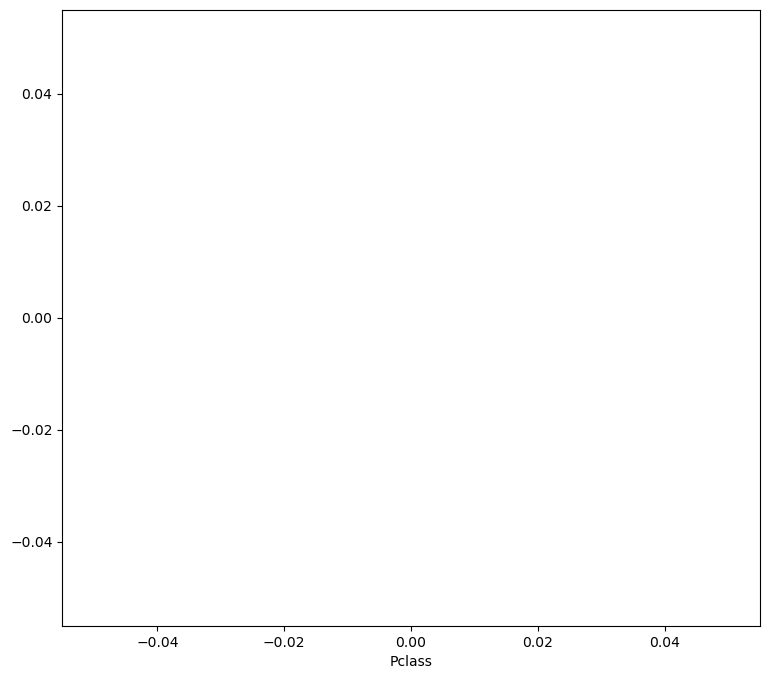

In [7]:
plt.figure(figsize=(9, 8))
survived_males = train_df[(train_df['Survived'] == 1) & (train_df['Embarked'] == "male")]
#survived_males.head(3)
sns.distplot(survived_males['Pclass'], color='g', bins=100, hist_kws={'alpha': 0.4})

In [62]:
train_df[['Last_name', 'First_name']] = train_df['Name'].str.split(',', n=1, expand=True) 
train_df['Title'] = train_df['Name'].map(lambda x: x.split(',')[1].split('.')[0])
train_df['Title'].value_counts()
#train_df.head(4)

Title
 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: count, dtype: int64

In [74]:
df = train_df[['Title', 'Age', 'Fare', 'Survived']].groupby('Title').mean()
df

,Age,Fare,Survived
Title,,,
Capt,70.000000,71.000000,0.000000
Col,58.000000,31.025000,0.500000
Don,40.000000,27.720800,0.000000
Dr,42.000000,49.168457,0.428571
Jonkheer,38.000000,0.000000,0.000000
Lady,48.000000,39.600000,1.000000
Major,48.500000,28.525000,0.500000
Master,4.574167,34.703125,0.575000
Miss,21.773973,43.797873,0.697802


In [77]:
pd.set_option('display.max_rows', None)
train_df[(train_df['Survived'] == 1) & (train_df['Embarked'] == "S")]
#survived_males['Pclass'].value_counts()
#pd.reset_option('all')

PassengerId  Survived  Pclass  Name                                                      Sex     Age    SibSp  Parch  Ticket             Fare      Cabin        Embarked  Last_name               First_name                                         Title        
4            1         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)              female  35.00  1      0      113803             53.1000   C123         S         Futrelle                 Mrs. Jacques Heath (Lily May Peel)                 Mrs             1
718          1         2       Troutt, Miss. Edwina Celia "Winnie"                       female  27.00  0      0      34218              10.5000   E101         S         Troutt                   Miss. Edwina Celia "Winnie"                        Miss            1
708          1         1       Calderhead, Mr. Edward Pennington                         male    42.00  0      0      PC 17476           26.2875   E24          S         Calderhead               Mr. Edward Penning

In [21]:
preprocessor = DataPreprocessor()
X_train, y_train = preprocessor.preprocess_dataset(train_df)
X_train.head(5)

,Age,Male,is_Officer,is_Mr,is_Miss,is_Mrs,is_Master,is_Royalty,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,FamilySize,FarePerPerson
0,22.0,True,False,True,False,False,False,False,False,False,True,False,False,True,1,3.62500
1,38.0,False,False,False,False,True,False,False,True,False,False,True,False,False,1,35.64165
2,26.0,False,False,False,True,False,False,False,False,False,True,False,False,True,0,7.92500
3,35.0,False,False,False,False,True,False,False,False,False,True,True,False,False,1,26.55000
4,35.0,True,False,True,False,False,False,False,False,False,True,False,False,True,0,8.05000


In [5]:
import rftuner1 as rft
import uuid

mlflow_exp_name = "titanic-hyp-" + str(uuid.uuid4()).split("-")[0]
preprocessor = DataPreprocessor()

best_params = rft.tune_model(train_df, 
                         n_trials=150, 
                         preprocessor=preprocessor,
                         study_name=mlflow_exp_name,
                         mlflow_tracking_uri=mlflow_tracking_uri)

mlflow.set_experiment("titanic")
mlflow.sklearn.autolog(disable=True)
with mlflow.start_run(run_name='rf_baseline'):
    mlflow.set_tag("model_name", "RF")    

    model = RandomForestClassifier(**best_params)
    param = model.get_params()
    
    X_train, y_train = preprocessor.preprocess_dataset(train_df)

    model.fit(X_train, np.ravel(y_train))

    acc = kCrossVal(k = 5, 
                    model_class = RandomForestClassifier, 
                    model_params = param, 
                    data = train_df,
                    preprocessor=preprocessor)

    joined_train = pd.concat((X_train,y_train),axis=1)
    mlflow_train_dataset: PandasDataset = mlflow.data.from_pandas(joined_train)
    mlflow.log_input(mlflow_train_dataset, context="training")
    mlflow.log_params(params=param)
    mlflow.log_metric("accuracy", acc)
    signature = infer_signature(model_input=X_train, model_output=y_train)
    mlflow.sklearn.log_model(model, "sk_models", signature=signature)

    print(acc)
        

/media/tomislav/023ABC973ABC8965/Projekti/MLOps-Testing/src/rftuner1.py:17: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(
/media/tomislav/023ABC973ABC8965/Projekti/MLOps-Testing/src/rftuner1.py:28: ExperimentalWarning: track_in_mlflow is experimental (supported from v2.9.0). The interface can change in the future.
  @mlflc.track_in_mlflow()
2023/09/18 13:30:11 INFO mlflow.tracking.fluent: Experiment with name 'titanic-hyp-176c5a8a' does not exist. Creating a new experiment.


/home/tomislav/mambaforge-pypy3/envs/titanic_env/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/home/tomislav/mambaforge-pypy3/envs/titanic_env/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-inte

0.8274717514124295


In [18]:
import filecmp
old_submission = '../kaggle/titanic/submission1.csv'
new_submission = '../kaggle/titanic/submission.csv'

if os.path.exists(new_submission):
    os.remove(new_submission)

logged_model = 'runs:/5609308f3f7640a9bf215a25c5270995/sk_models'

ml_model = mlflow.sklearn.load_model(logged_model)

X_test = preprocessor.preprocess_dataset(test_df, test=True)

predictions = ml_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId,
                       'Survived': predictions})
output.to_csv(new_submission, index=False)

is_diff = filecmp.cmp(old_submission, new_submission, shallow=False)

print("New submission same as old? " + str(is_diff))
print("Your submission was successfully saved!")

New submission same as old? False
Your submission was successfully saved!


In [22]:
X_test = preprocessor.preprocess_dataset(test_df, test=True)

predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId,
                       'Survived': predictions})
output.to_csv('../kaggle/titanic/submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


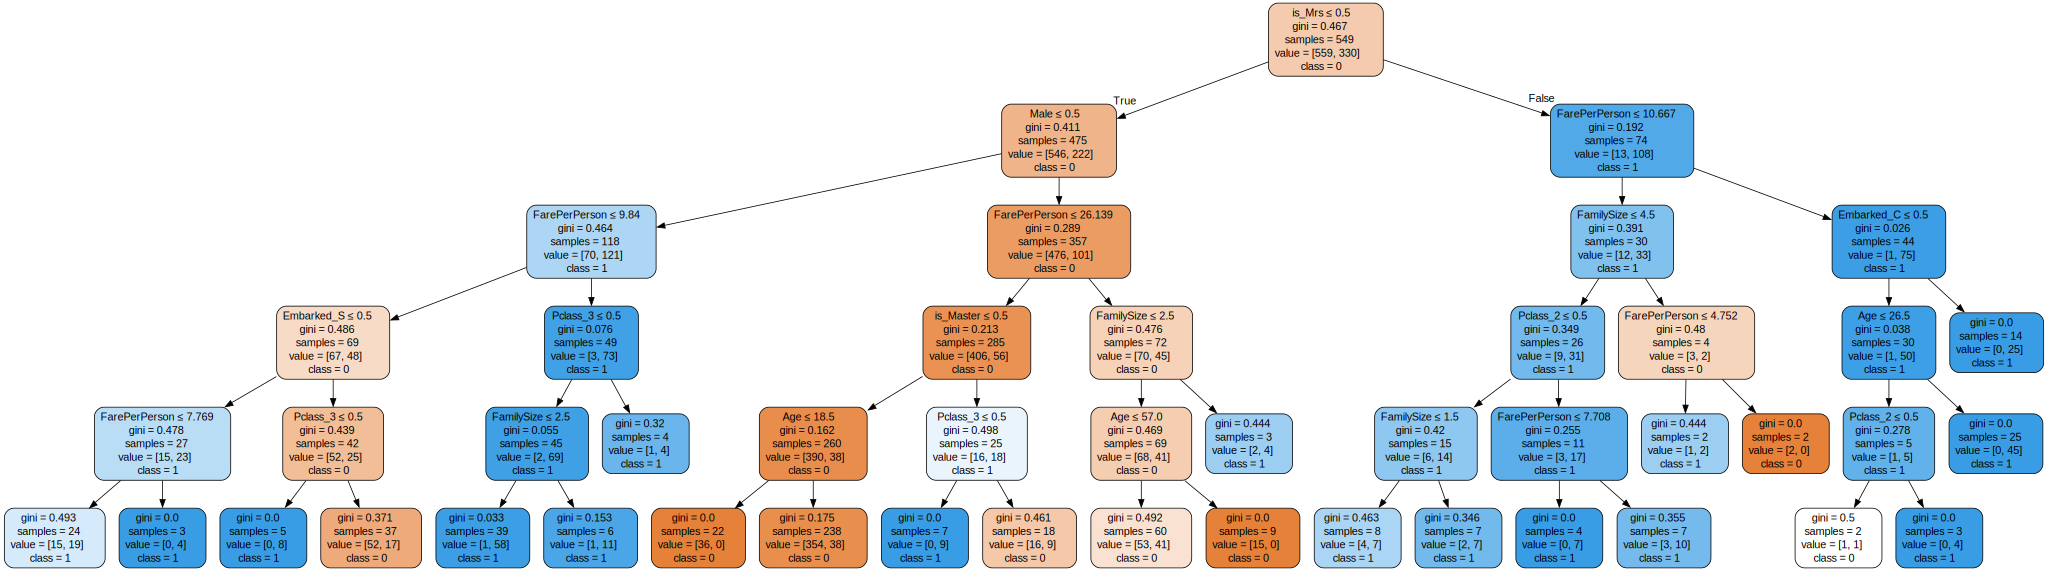

In [9]:
import graphviz  
from sklearn.tree import export_graphviz  
dot_data= export_graphviz(model.estimators_[10], out_file = None, 
                    feature_names = X_train.columns,  
                      class_names = ['0', '1'],  
                      filled = True, rounded = True,  
                      special_characters = True, impurity = True)  
graph = graphviz.Source(dot_data, format='png')  
graph  